In [45]:
import pandas as pd

from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt

import ast


In [12]:

df_made_train = pd.read_csv("datasets/recipes_made_train.csv")
df_made_test = pd.read_csv("datasets/recipes_made_test.csv")
df_made_val = pd.read_csv("datasets/recipes_made_val.csv")
df_raw_interactions = pd.read_csv("datasets/RAW_interactions.csv")
df_raw_recipes = pd.read_csv("datasets/RAW_recipes.csv")
df_pp_users = pd.read_csv("datasets/PP_users.csv")
df_pp_recipes = pd.read_csv("datasets/PP_recipes.csv")
df_train = pd.read_csv("datasets/interactions_train.csv")
df_test = pd.read_csv("datasets/interactions_test.csv")
df_val = pd.read_csv("datasets/interactions_validation.csv")
df_ingr_map = pd.read_csv("datasets/ingr_map.csv")

In [33]:
# Cleaning raw recipe to remove recipes that take longer than 1 day, have more than 25 steps, and more than 40 ingredients
df_rr_clean = df_raw_recipes[df_raw_recipes['minutes'] <= 1440]
df_rr_clean = df_rr_clean[df_rr_clean['n_ingredients'] <= 25]
df_rr_clean = df_rr_clean[df_rr_clean['n_steps'] <= 40]

# Dropping date, u, and i columns
df_train_clean = df_train.drop(["date", "u", "i"], axis=1)
df_test_clean = df_test.drop(["date", "u", "i"], axis=1)
df_val_clean = df_val.drop(["date", "u", "i"], axis=1)

# Removing any recipes that were removed from cleaning the raw recipes
df_train_clean = df_train_clean[df_train_clean['recipe_id'].isin(df_rr_clean['id'])]
df_test_clean = df_test_clean[df_test_clean['recipe_id'].isin(df_rr_clean['id'])]
df_val_clean = df_val_clean[df_val_clean['recipe_id'].isin(df_rr_clean['id'])]

# Removing any recipes that were removed from cleaning the raw recipes
df_made_train = df_made_train[df_made_train['recipe_id'].isin(df_rr_clean['id'])]
df_made_test = df_made_test[df_made_test['recipe_id'].isin(df_rr_clean['id'])]
df_made_val = df_made_val[df_made_val['recipe_id'].isin(df_rr_clean['id'])]


In [16]:
# Normalize content-based features
scaler = StandardScaler()
df_rr_clean['min_normalized'] = scaler.fit_transform(df_rr_clean[['minutes']])
df_rr_clean['n_steps_normalized'] = scaler.fit_transform(df_rr_clean[['n_steps']])
df_rr_clean['n_ingr_normalized'] = scaler.fit_transform(df_rr_clean[['n_ingredients']])

# Convert nutrition strings into a list
df_rr_clean['nutrition'] = df_rr_clean['nutrition'].apply(ast.literal_eval)
    

In [17]:
def convToMap(data, value_cols):
    if isinstance(value_cols, str):
        value_cols = [value_cols]

    for col in ['id'] + value_cols:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
    
    if(len(value_cols) == 1):
        value_map_1 = defaultdict(set)
        for _, row in data.iterrows():
            value_map_1[row['id']].add(row[value_cols[0]])
        return value_map_1
    else:
        value_map_mult = defaultdict(list)
        for _, row in data.iterrows():
            for col in value_cols:
                value_map_mult[row['id']].append(row[col])
        return value_map_mult

In [18]:
id_to_recipe = convToMap(df_rr_clean, ["min_normalized", "nutrition", "n_steps_normalized", "n_ingr_normalized"])

In [23]:
id_to_recipe[4684.0]

[0.10526539445755662,
 [487.8, 16.0, 283.0, 13.0, 52.0, 20.0, 26.0],
 -0.6489417598417637,
 0.26693693060092955]

In [34]:

train = defaultdict(list)
for _, data in df_made_train.iterrows():
    recipe = id_to_recipe[data.iloc[1]]
    train['user_id'].append(data.iloc[0])
    train['min_normalized'].append(recipe[0])
    train['calories'].append(recipe[1][0])
    train['total_fat'].append(recipe[1][1])
    train['sugar'].append(recipe[1][2])
    train['sodium'].append(recipe[1][3])
    train['protein'].append(recipe[1][4])
    train['saturated_fat'].append(recipe[1][5])
    train['carbohydrates'].append(recipe[1][6])
    train['n_steps_normalized'].append(recipe[2])
    train['n_ingr_normalized'].append(recipe[3])

X = pd.DataFrame(train)

    


In [35]:
X.head()

,user_id,min_normalized,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates,n_steps_normalized,n_ingr_normalized
0,2046,0.105265,487.8,16.0,283.0,13.0,52.0,20.0,26.0,-0.648942,0.266937
1,2046,0.843935,368.4,33.0,15.0,35.0,55.0,44.0,5.0,0.955425,2.993820
2,1773,2.101671,756.6,68.0,47.0,115.0,93.0,72.0,13.0,1.668477,1.903067
3,1773,0.604367,163.2,12.0,2.0,11.0,7.0,22.0,5.0,1.490214,-0.278440
4,2046,-0.643387,525.6,69.0,42.0,6.0,8.0,74.0,10.0,0.420636,-0.823816


In [36]:
len(X)

1389404

In [37]:
len(df_made_train['made'])

1389404

In [39]:
y = df_made_train['made']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [41]:
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5005703880438029

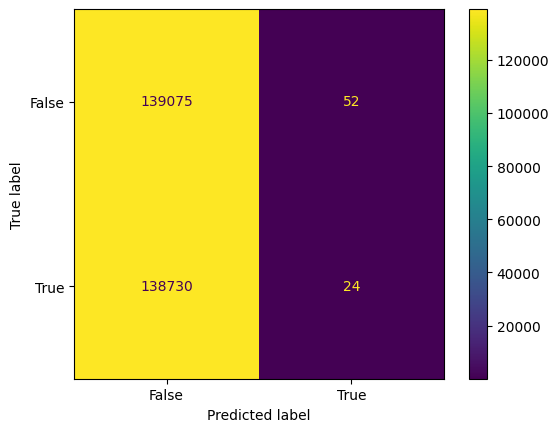

In [ ]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
